##### Importando as bibliotecas

In [1]:
# Importando as bibliotecas
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import seaborn as sns
import time

# Bibliotecas para o modelo de rede neural convolucional
import tensorflow as tf

# Bibliotecas para avaliação do modelo
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

tf.get_logger().setLevel('ERROR')


##### Preparação dos dados

In [2]:
# Declarando variáveis

# Caminho dos datasets
path = './chest_xray/'
normal_classe = 'NORMAL'
class_names = ['NORMAL', 'PNEUMONIA']

# Treino
treinamento_folder = os.path.join(path, 'train/')
treinamento_normal_dir = os.path.join(treinamento_folder, class_names[0])
treinamento_pneumonia_dir = os.path.join(treinamento_folder, class_names[1])

# Teste
teste_folder = os.path.join(path, 'test/')
teste_normal_dir = os.path.join(teste_folder, class_names[0])
teste_pneumonia_dir = os.path.join(teste_folder, class_names[1])
percent_test = 25

# Tamanho das imagens
img_width = 196
img_height = 196

# Variáveis para o treinamento
batch_size = 32
epochs = 200
learning_rate = 0.0005
patience = 20


In [3]:
# Carregando as bases de dados

# Carregando o dataset de treinamento
dataset_treinamento = tf.keras.preprocessing.image_dataset_from_directory(
    treinamento_folder,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True
)

# Carregando o dataset de teste
dataset_teste_original = tf.keras.preprocessing.image_dataset_from_directory(
    teste_folder,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True
)


Found 5206 files belonging to 2 classes.
Found 666 files belonging to 2 classes.


In [4]:
# Separando o dataset de teste em validação e teste

dataset_test_cardinality = tf.data.experimental.cardinality(
    dataset_teste_original)

# Dividindo o dataset de teste em validação e teste onde 75% é para validação e 25% para teste
dataset_test_bathes = dataset_test_cardinality // int((100 / percent_test))

dataset_teste = dataset_teste_original.take(dataset_test_bathes)
dataset_validacao = dataset_teste_original.skip(dataset_test_bathes)


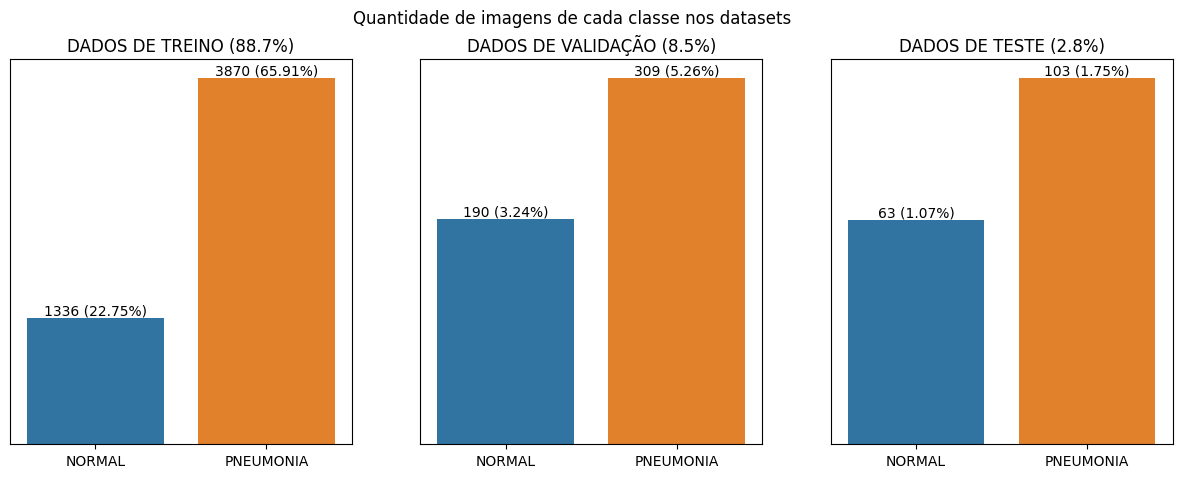

In [5]:
# Calculando a quantidade de imagens de cada classe para exibir nos gráficos
len_treinamento_normal = len(os.listdir(treinamento_normal_dir))
len_treinamento_pneumonia = len(os.listdir(treinamento_pneumonia_dir))
len_teste_normal = len(os.listdir(teste_normal_dir))
len_teste_pneumonia = len(os.listdir(teste_pneumonia_dir))

qtd_total = len_treinamento_normal + len_treinamento_pneumonia + \
    len_teste_normal + len_teste_pneumonia

validacao_quantidade_normal = int(
    (len_teste_normal) * (1 - (percent_test / 100)))
validacao_quantidade_pneumonia = int(
    (len_teste_pneumonia) * (1 - (percent_test / 100)))

teste_quantidade_normal = int((len_teste_normal) * (percent_test / 100))
teste_quantidade_pneumonia = int((len_teste_pneumonia) * (percent_test / 100))


def plot_quantidade(len_normal, len_pneumonia, title='', i=1):
    # Função para exibir graficos de barras com a quantidade de imagens de cada classe nos datasets

    plt.subplot(1, 3, i)
    sns.barplot(x=class_names, y=[len_normal, len_pneumonia])

    len_total = len_normal + len_pneumonia
    percentage_total = round(((len_total) / qtd_total) * 100, 2)
    percentage_normal = round((len_normal / (qtd_total)) * 100, 2)
    percentage_pneumonia = round((len_pneumonia / (qtd_total)) * 100, 2)

    plt.title(title+f' ({percentage_total:.1f}%)')

    plt.text(0, len_normal,
             f'{len_normal} ({percentage_normal}%)', ha='center', va='bottom')
    plt.text(1, len_pneumonia,
             f'{len_pneumonia} ({percentage_pneumonia}%)', ha='center', va='bottom')

    plt.yticks([])


plt.figure(figsize=(15, 5))
plt.suptitle('Quantidade de imagens de cada classe nos datasets')

plot_quantidade(len_treinamento_normal,
                len_treinamento_pneumonia, f'DADOS DE TREINO', 1)
plot_quantidade(validacao_quantidade_normal,
                validacao_quantidade_pneumonia, 'DADOS DE VALIDAÇÃO', 2)
plot_quantidade(teste_quantidade_normal,
                teste_quantidade_pneumonia, 'DADOS DE TESTE', 3)


In [6]:
# Data Augmentation

# Criando um gerador de imagens para aplicar Data Augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #  Random Horizontal Flip - para lidar com os sintomas de pneumonia presentes nos dois lados do tórax
    horizontal_flip=True,
    #  Random Zoom - para obter uma maior relação entre os pixels.
    zoom_range=0.25,
    #  Random Rotation - para lidar com as imagens que podem estar em diferentes ângulos
    rotation_range=15,
    # Random Shift - para lidar com as imagens que podem estar em diferentes posições
    width_shift_range=0.1,
    height_shift_range=0.1,
)

# Aplicando Data Augmentation na base de treinamento
train_generator = datagen.flow_from_directory(
    treinamento_folder,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')


Found 5206 images belonging to 2 classes.


<Figure size 640x480 with 0 Axes>

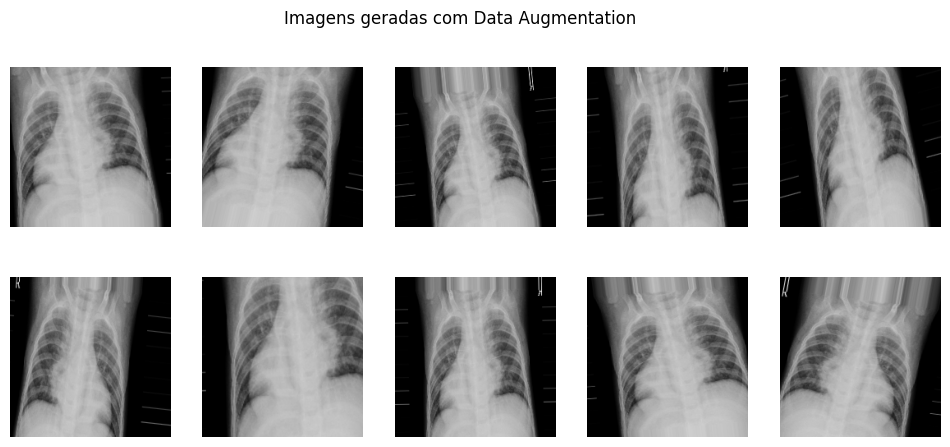

In [7]:
# Exibindo imagens geradas com Data Augmentation a partir de uma única imagem
def plot_dataset_data_augmentation(dataset):
    plt.gcf().clear()
    plt.figure(figsize=(12, 5))
    plt.suptitle('Imagens geradas com Data Augmentation')

    for features, _ in dataset.take(1):
        feature = features[0].numpy().astype("uint8")
        for i in range(10):
            aug_img = datagen.random_transform(feature)
            plt.subplot(2, 5, i + 1)
            plt.axis('off')
            plt.imshow(aug_img)

    plt.show()


plot_dataset_data_augmentation(dataset_treinamento)


##### Criação e treinamento do modelo


In [8]:
# Modelagem COM Transferência de Aprendizado
# Aqui vamos preparar o modelo de acordo com nossos requisitos

# Vamos preparar nossa camada de entrada para passar o tamanho da imagem. o padrão é (224,224,3).
# Vamos alterá-lo para o tamanho da imagem que estamos usando.
input_layer = tf.keras.Input(shape=(img_width, img_height, 3))

# Inicializando o modelo de transferência  com as propriedades apropriadas para nossas necessidades.
# Estamos passando parâmetros como:
# 1) weights='imagenet' - Usando isso, estamos carregando os pesos como os pesos originais.
# 2) input_tensor para passar o modelo usando a camada de entrada que criamos.
# 3) Queremos alterar a última camada, então não estamos incluindo a camada superior

model_tl = tf.keras.applications.MobileNetV3Small(
    weights='imagenet', input_tensor=input_layer, include_top=False)



In [9]:
# Criando o modelo
model = tf.keras.Sequential([
    # Adicionando a camada de entrada com transferência de aprendizado
    model_tl,

    # # Adicionando Flatten e Dense para a camada de saída final
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Sumário do modelo final com as camadas adicionadas
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 28224)             0         
                                                                 
 dense (Dense)               (None, 2)                 56450     
                                                                 
Total params: 995,570
Trainable params: 983,458
Non-trainable params: 12,112
_________________________________________________________________


In [10]:
# Compilando o modelo e definindo o otimizador e a função de perda
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=learning_rate
    ),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)


In [11]:
# Treinamento do modelo

# Monitora a perda de validação e interrompe o treinamento quando a perda
# de validação não melhora por muitas épocas consecutivas para evitar overfitting
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=patience,
    restore_best_weights=True,
    verbose=1
)

# Salvando o melhor modelo a partir da loss para
# recuperar em caso de interrupção
checkpoint_loss = tf.keras.callbacks.ModelCheckpoint(
    'models/best_model_loss.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    period=1,
)

# Salvando o melhor modelo a partir da accuracy para
# recuperar em caso de interrupção
checkpoint_accuracy = tf.keras.callbacks.ModelCheckpoint(
    'models/best_model_accuracy.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    period=1,
)


# Tempo inicial do treinamento
t0 = time.time()

history = model.fit(
    train_generator,
    epochs=epochs,
    batch_size=batch_size,
    verbose=True,
    validation_data=dataset_validacao,
    callbacks=[earlystopping, checkpoint_loss, checkpoint_accuracy],
)

# Tempo final do treinamento
t1 = time.time()

loss, accuracy = model.evaluate(dataset_teste)

print('Loss: {:.2f}'.format(loss))
print('Accuracy: {:.2f}'.format(accuracy))
print('Tempo total do treinamento: {:.2f} segundos'.format(t1 - t0))


Epoch 1/200
163/163 [==============================] - ETA: 0s - loss: 0.2321 - accuracy: 0.9353
Epoch 1: val_loss improved from inf to 2.52965, saving model to models\best_model_loss.h5

Epoch 1: val_accuracy improved from -inf to 0.66008, saving model to models\best_model_accuracy.h5
163/163 [==============================] - 168s 984ms/step - loss: 0.2321 - accuracy: 0.9353 - val_loss: 2.5297 - val_accuracy: 0.6601
Epoch 2/200
163/163 [==============================] - ETA: 0s - loss: 0.1169 - accuracy: 0.9631
Epoch 2: val_loss improved from 2.52965 to 1.84125, saving model to models\best_model_loss.h5

Epoch 2: val_accuracy improved from 0.66008 to 0.68972, saving model to models\best_model_accuracy.h5
163/163 [==============================] - 180s 1s/step - loss: 0.1169 - accuracy: 0.9631 - val_loss: 1.8412 - val_accuracy: 0.6897
Epoch 3/200
163/163 [==============================] - ETA: 0s - loss: 0.0910 - accuracy: 0.9662
Epoch 3: val_loss did not improve from 1.84125

Epoch 3

In [12]:
# Salvando o modelo
data_atual = datetime.now().strftime('%d-%m-%Y')
model.save(f'models/modelo_tcc_{data_atual}.h5')


In [82]:
model.load_weights(f'models/modelo_tcc_{data_atual}.h5')


<Figure size 640x480 with 0 Axes>

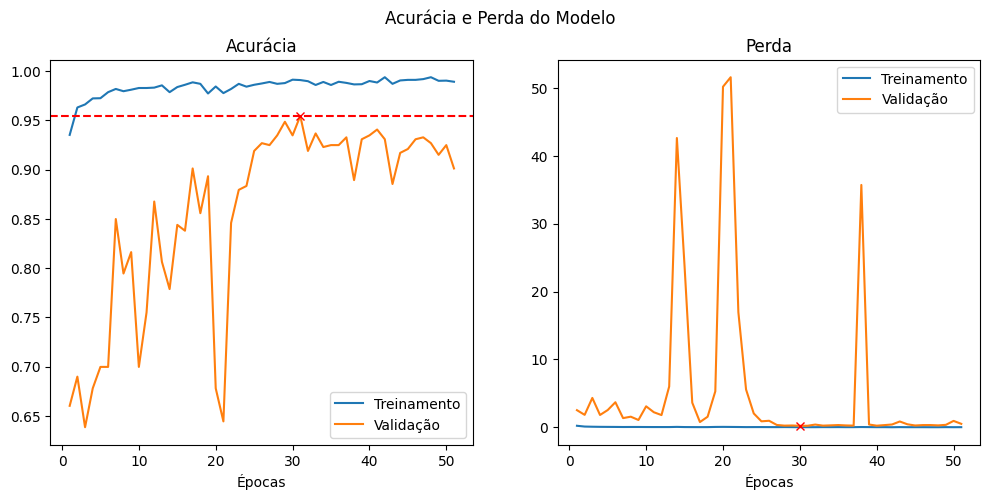

In [83]:
# Função para plotar gráficos de acurácia e loss do modelo
def plot_model(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, len(accuracy) + 1)

    plt.gcf().clear()
    plt.figure(figsize=(12, 5))

    plt.suptitle('Acurácia e Perda do Modelo')

    plt.subplot(1, 2, 1)
    plt.title('Acurácia')
    plt.plot(epochs_range, accuracy, label='Treinamento')
    plt.plot(epochs_range, val_accuracy, label='Validação')
    plt.legend(loc='lower right')

    plt.plot(np.argmax(val_accuracy)+1, np.max(val_accuracy),
             marker='x', color='r', label='Melhor acurácia')
    plt.axhline(y=np.max(val_accuracy), color='r', linestyle='--')

    plt.xlabel('Épocas')

    plt.subplot(1, 2, 2)
    plt.title('Perda')
    plt.plot(epochs_range, loss, label='Treinamento')
    plt.plot(epochs_range, val_loss, label='Validação')
    plt.legend(loc='upper right')

    plt.plot(np.argmin(val_loss)+1, np.min(val_loss),
             marker='x', color='r', label='Melhor perda')

    plt.xlabel('Épocas')


plot_model(history)


##### Validação do modelo


In [115]:
# Função para obter os resultados do modelo
def get_results(dataset):
    count = 0
    label_list = []
    prediction_list = []
    features_list = []
    percentages = []

    for features, labels in dataset:
        predictions = model.predict(features)
        for i in range(batch_size):
            label = np.argmax(labels[i])
            label_list.append(label)
            features_list.append(features[i])

            percentages.append(predictions[i][np.argmax(predictions[i])])
            prediction_list.append(np.argmax(predictions[i]))
            count += 1

            if (i+1 == len(predictions)):
                break

    return features_list, label_list, prediction_list, percentages


val_features, val_labels, val_predictions, val_percentages = get_results(
    dataset_validacao)
test_features, test_labels, test_predictions, test_percentages = get_results(
    dataset_teste)


1/1 [==============================] - 0s 199ms/step


In [118]:
def plot_results(features, labels, predictions, percentages, title, only_errors=False, num_rows=3, num_cols=5):
    total = num_rows*num_cols

    fig = plt.figure(figsize=(2*num_cols, 2*num_rows))
    fig.suptitle(title, fontsize=16)

    j = 0
    index_used = []

    def get_random_index():
        if (len(index_used) == len(predictions)):
            raise Exception("Todas as imagens já foram plotadas")

        index = random.randint(0, len(predictions)-1)
        if (index in index_used):
            return get_random_index()
        else:
            index_used.append(index)
            return index

    for p in range(len(predictions)):
        if (j >= total):
            break

        i = get_random_index()

        true_label = labels[i]

        predicted_label = predictions[i]

        if (only_errors and predicted_label == true_label):
            continue

        j += 1
        plt.subplot(num_rows, num_cols, j)

        plt.grid(False)
        plt.xticks([])
        plt.yticks([])

        plt.imshow(features[i].numpy().astype('uint8'), cmap=plt.cm.binary)

        if (predicted_label == true_label):
            color = 'green'
        else:
            color = 'red'

        percentage = percentages[i]*100

        plt.xlabel("P: {} {:2.0f}% \n R:{}".format(
            class_names[predicted_label], percentage, class_names[true_label]), color=color, fontsize=10)

    plt.subplots_adjust(hspace=0.4)

    plt.figtext(0.5, 0.01, "P: Predição | R: Real", ha="center", fontsize=12, bbox={
                    "facecolor": "white", "alpha": 0.5, "pad": 5})


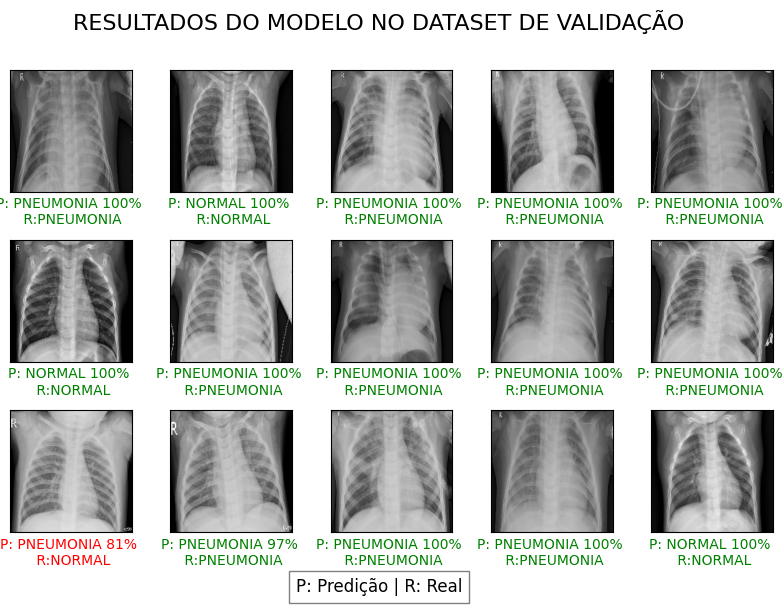

In [119]:
# Plotando os resultados do modelo no dataset de validacao
plot_results(val_features, val_labels, val_predictions,
             val_percentages, "RESULTADOS DO MODELO NO DATASET DE VALIDAÇÃO")


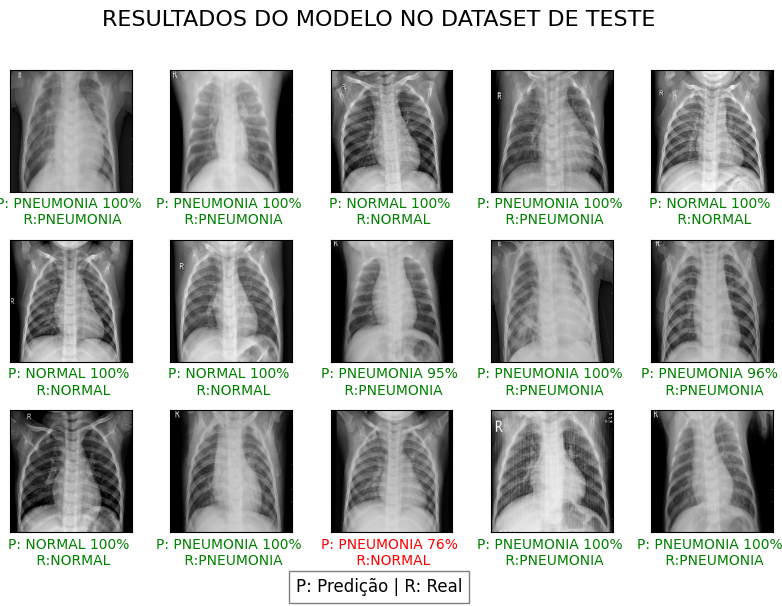

In [135]:
# Plotando os resultados do modelo no dataset de teste
plot_results(test_features, test_labels, test_predictions,
             test_percentages, "RESULTADOS DO MODELO NO DATASET DE TESTE")


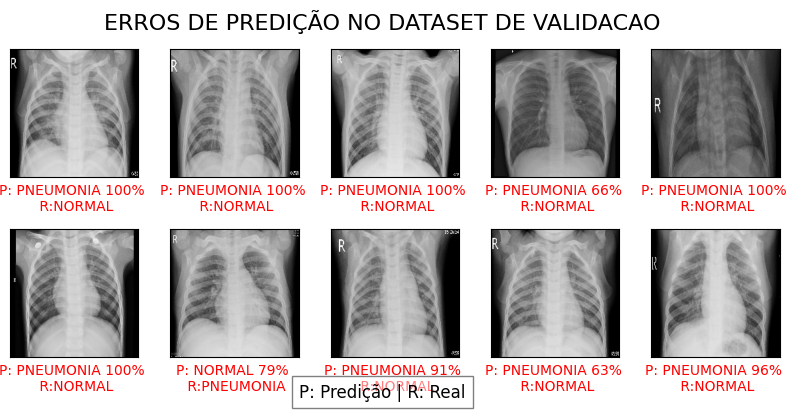

In [147]:
# Plotando os resultados do modelo no dataset de teste
plot_results(val_features, val_labels, val_predictions, val_percentages,
             "ERROS DE PREDIÇÃO NO DATASET DE VALIDACAO", True, 2, 5)


Porcentagem de acerto - VALIDAÇÃO: 96.2%
Porcentagem de acerto - TESTE: 96.9%


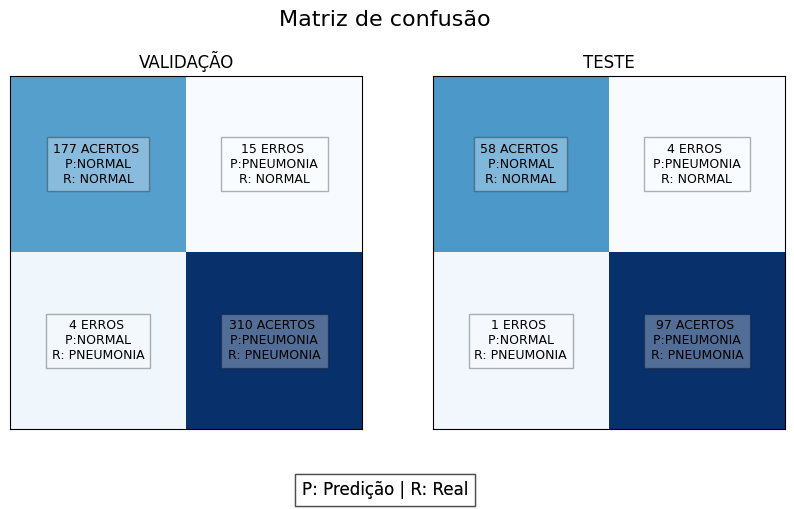

In [148]:
# Matriz de confusão
plt.figure(figsize=(10, 5))
plt.suptitle("Matriz de confusão", fontsize=16)


def plot_confusion_matrix(predictions, labels, title, i=1):
    # Função para plotar a matriz de confusão
    plt.subplot(1, 2, i)
    matrix = confusion_matrix(labels, predictions)
    porcentagem_acerto = (matrix[0, 0] + matrix[1, 1]) / np.sum(matrix) * 100

    print(f'Porcentagem de acerto - {title}: {round(porcentagem_acerto, 1)}%')

    plt.imshow(matrix, cmap=plt.cm.Blues, interpolation='nearest')

    # Adicionando os nomes das classes e os valores
    for i in range(2):
        for j in range(2):
            text = 'ACERTO' if i == j else 'ERRO'
            text_final = f'{matrix[i, j]} {text}S \n P:{class_names[i]} \nR: {class_names[j]}'
            plt.text(i, j, text_final, va='center', ha='center', color='black', bbox=dict(
                facecolor='white', alpha=0.3), fontsize=9)

    plt.title(title)

    plt.tick_params(left=False, right=False, labelleft=False,
                    labelbottom=False, bottom=False)

    plt.figtext(0.5, 0.01, "P: Predição | R: Real", ha="center",
                fontsize=12, bbox={"facecolor": "white", "alpha": 0.5, "pad": 5})


plot_confusion_matrix(val_labels, val_predictions,
                      title='VALIDAÇÃO', i=1)
plot_confusion_matrix(test_labels, test_predictions,
                      title='TESTE', i=2)


(0.9717234435307938, 0.9626398946675444, 0.9667760289048548, None)

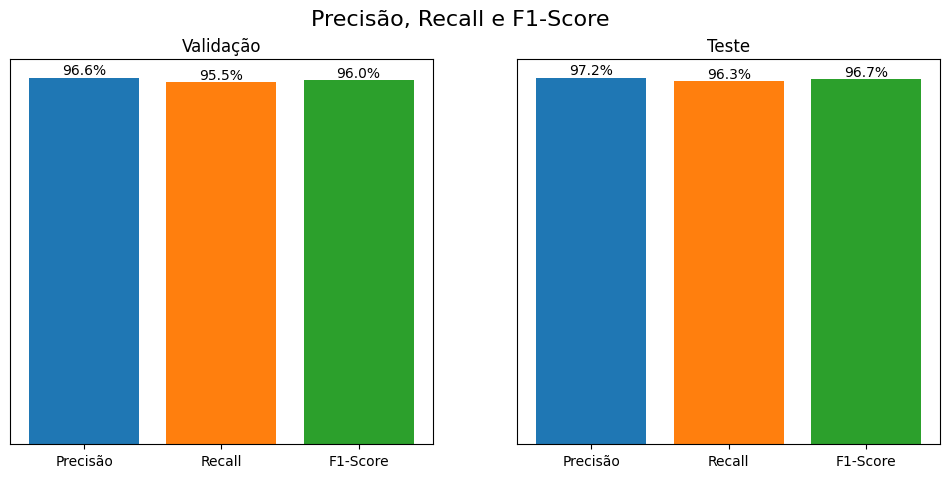

In [149]:
# Gráfico de precisão, recall e f1-score
plt.figure(figsize=(12, 5))
plt.suptitle("Precisão, Recall e F1-Score", fontsize=16)


def plot_precision(predictions, labels, title='Precisão', i=1):
    precision = precision_recall_fscore_support(
        labels, predictions, average='macro')

    plt.subplot(1, 2, i)
    plt.bar(['Precisão'], precision[0])
    plt.bar(['Recall'], precision[1])
    plt.bar(['F1-Score'], precision[2])

    def format_precision(val):
        return f'{round(val*100, 1)}%'

    # Exibindo os valores de precisão, recall e f1-score
    plt.text(0, precision[0], format_precision(
        precision[0]), ha='center', va='bottom')
    plt.text(1, precision[1], format_precision(
        precision[1]), ha='center', va='bottom')
    plt.text(2, precision[2], format_precision(
        precision[2]), ha='center', va='bottom')
    plt.title(title)

    plt.yticks([])
    return precision


plot_precision(val_predictions, val_labels,
               title='Validação', i=1)
plot_precision(test_predictions, test_labels,
               title='Teste', i=2)
